## The effect of agriculture on the population of breeding birds in the Netherlands


### Introduction

The biodiversity of our planet is very essential for all the living organisms on earth. Unfortunately, the biodiversity has changed fast in the last decades. This change is caused mainly by human activities like agriculture. Agriculture can be harmful for ecosystems and can cause the loss of biodiversity. Even in the Netherlands there has been a loss of biodiversity during the last decades because of agriculture. 

This research focusses on the breeding bird population in the Netherlands. Birds are very important and are part of the biodiversity. They play an important role in the food chain and in the pollution of plants.

### Research question

What is the effect of agriculture on the population of breeding birds in the Netherlands?

### The data

Two datasets were used during this research. Both came from a different source.

The agriculture data came from Centraal Bureau voor Statestiek (CBS)
https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS&tableId=80781ned&_theme=302

The bird population data came from sovon
https://sovon.nl/indexen-en-aantallen




### Code 

In [ ]:
# The imports

import yaml
import pandas as pd
from datetime import datetime
from bokeh.plotting import figure, show, ColumnDataSource
import numpy as np
import re
import pandas as pd
import panel as pn
from bokeh.io import output_notebook
from bokeh.models import LinearAxis, Range1d
# import geopandas as gpd



### Creating dataframes from the files

In [ ]:
def opening_file(file_name):
    with open("config.yaml", "r") as config_reader:
        files = yaml.safe_load(config_reader)
        file_reader = pd.read_csv(files[file_name], sep="\t")
    return file_reader


def form_dataframe(file_name, start_index, end_index, is_birdfile):
    
    # Renaming the column so it is easier to use
    column_name = [col for col in file_name][0]
    file_name.rename(columns = {column_name:'data_column'}, inplace = True)
    
    # Adding the column names of the agriculture dataframe on top of the dataframe. The column names will then spi
    if is_birdfile == False:
        top_row = pd.DataFrame({"data_column" : column_name}, index =[0])
        file_name = pd.concat([top_row, file_name]).reset_index(drop = True)
  
    # Creating the dataframe
    df_x = file_name.loc[start_index:end_index].copy()
    df_x = df_x.data_column.str.split(";",expand=True)
    
    if is_birdfile == False:
        for column in df_x:
            df_x[column] = df_x[column].str[1:-1]      
    
    df_x.columns = df_x.iloc[0]
    df_x = df_x.iloc[1:]
    
    return df_x



### Reforming the bird dataframe

In [ ]:
def reform_bird_df(bird_df):
    
    # Creating the dataframe with the usefull lines of the bird file
    bird_df = form_dataframe(bird_df, 1, 199, True)
    
    # Converting all the different year columns to one column
    bird_df = bird_df.melt(id_vars=["nr.", "Soort", "Wetenschappelijke naam", "English name", "Provincie", "Trend 1990-2020", "Percentage jaarlijkse verandering vanaf 1990", "Trend 2009-2020", "Percentage jaarlijkse verandering vanaf 2009"], 
        var_name="Date", 
        value_name="Value")
    
    # Dropping columns to make the data_frame clearer
    bird_df.drop(bird_df.columns[[0,1,5,6,7,8]], axis=1, inplace=True)
    
    # Translating the names to english
    bird_df = bird_df.rename(columns = {"English name":'Species', "Wetenschappelijke naam" : "Scientific_name", "Provincie" : "Region"})
    
    # Selecting the timeframe 2000 till 2020
    bird_df["Date"] = bird_df["Date"].astype(int)
    bird_df = bird_df.loc[bird_df["Date"].isin([year for year in range(2000, 2021)])]
    
    # Filling the blank values with Nan
    bird_df = bird_df.replace(r'^\s*$', np.nan, regex=True)
    bird_df["Value"] = bird_df["Value"].astype("float")
    
    return bird_df

# Checking the dataframe
bird_df = reform_bird_df(opening_file("bird_file"))
bird_df

### Reforming the agriculture dataframe

In [ ]:
def reform_agriculture(agriculture_file,):
    # A dictionairy for all the region codes
    region_dictionairy = {"PV20  " : "Groningen",
                      "PV21  " : "Friesland",
                      "PV22  " : "Drenthe",
                      "PV23  " : "Overijssel",
                      "PV24  " : "Flevoland",
                      "PV25  " : "Gelderland",
                      "PV26  " : "Utrecht",
                      "PV27  " : "Noord_Holland",
                      "PV28  " : "Zuid_Holland",
                      "PV29  " : "Zeeland",
                      "PV30  " : "Noord_Brabant",
                      "PV31  " : "Limburg"
                      }
    
    agriculture_df = form_dataframe(agriculture_file, 0, 278, False)
    
    # Translating the column names to english. I used a translator because of column amounts
    column_name_list = []
    renaming_list = []
    for column_name in agriculture_df:
        column_name= re.sub(r"_\d|\d+|S\Z", "", column_name)
        column_name = re.sub(r"(\w)([A-Z])", r"\1 \2", column_name)
        if column_name in column_name_list:
            column_name += " Bedrijven"
        column_name_list.append(column_name)
    
    
    # english_list = [GoogleTranslator('nl', 'en').translate(text = column_name) for column_name in column_name_list]
    
    # Creating a dictionairy with the dutch column as key and the english name as value
    zipped_tuples = zip([column for column in agriculture_df], column_name_list)
    agriculture_df = agriculture_df.rename(columns = {nl_name : en_name for nl_name, en_name in zipped_tuples})
    
    # Selecting the timeframe 2000 till 2020
    agriculture_df = agriculture_df.rename(columns = {"Perioden" : "Date", "Regio" : "Region"})
    agriculture_df["Date"] = agriculture_df["Date"].str[0:4].astype(int)
    agriculture_df = agriculture_df.loc[agriculture_df["Date"].isin([year for year in range(2000, 2021)])]
    
    # Replacing the regioncode with the region name
    agriculture_df.replace({"Region": region_dictionairy},inplace=True)
    
    # Replacing the blank values with Nan
    agriculture_df = agriculture_df.replace("       .", np.nan)
    
    # Turning the values into integers
    for column in agriculture_df:
        if column != "Region":
            agriculture_df[column] = agriculture_df[column].astype("float")
    

    
    
    return agriculture_df


# Checking the dataframe
agriculture_df = reform_agriculture(opening_file("agriculture_file"))
agriculture_df

### Testing the dataframes

In [6]:
# Checking if the dataframes are the same length (when only one bird species is selected from the dataframe)
print("The bird df has {} rows when one species is selected".format(len(bird_df.loc[bird_df["Species"] == "Grey Heron"])))
print("The agriculture df has {} rows".format(len(agriculture_df["Date"])))



The bird df has 252 rows when one species is selected
The agriculture df has 252 rows


### Merging the two dataset togheter per bird species

In [7]:
def create_df_dict(bird_df = bird_df, agriculture_df =agriculture_df):
    bird_list = bird_df["Species"].unique()
    bird_df_dict = {bird : bird_df.loc[bird_df["Species"] == bird] for bird in bird_list}
    
    df_dict = {bird:(agriculture_df.merge(bird_df_dict[bird], on= ["Date", "Region"], how='left')) for bird in bird_df_dict}
    
    return df_dict

# Checking if the function works
df_dict = create_df_dict()
df_dict["Greater Canada Goose"].interpolate()

,,Region,Date,Aantal Landbouwbedrijven Totaal,Grondgebruik Totaal,Cultuurgrond,Niet Cultuurgrond,Grondgebruik Totaal Bedrijven,Cultuurgrond Bedrijven,Niet Cultuurgrond Bedrijven,...,Vleeskuikens Bedrijven,Ouderdieren Van Vleeskuikens Bedrijven,Kalkoenen Bedrijven,Slachteenden Bedrijven,Overig Pluimvee Bedrijven,Konijnen Bedrijven,Edelpelsdieren Bedrijven,Scientific_name,Species,Value
0,1.0,Groningen,2000.0,4193.0,17540747.0,16610128.0,930619.00,4193.00,4156.0,3096.0,...,88.0,11.0,4.0,6.0,2.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,21.0
1,1.0,Groningen,2001.0,4034.0,17307887.0,16419061.0,888826.00,4034.00,3994.0,2905.0,...,89.0,6.0,5.0,7.0,4.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,45.0
2,1.0,Groningen,2002.0,3913.0,17525513.0,16600242.0,925271.00,3913.00,3877.0,2905.0,...,96.0,8.0,5.0,6.0,3.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,15.0
3,1.0,Groningen,2003.0,3752.0,18718093.0,16622248.0,2095845.00,3752.00,3719.0,2847.0,...,79.0,5.0,4.0,10.0,2.0,4.0,2.0,Branta canadensis canadensis,Greater Canada Goose,24.0
4,1.0,Groningen,2004.0,3713.0,17865125.0,16719827.0,1145298.00,3713.00,3683.0,2766.0,...,77.0,6.0,5.0,7.0,3.0,3.0,2.0,Branta canadensis canadensis,Greater Canada Goose,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,8.0,Limburg,2016.0,3893.0,10280736.0,9652748.0,627988.00,3893.00,3744.0,3626.0,...,45.0,13.0,18.0,1.0,0.0,5.0,23.0,Branta canadensis canadensis,Greater Canada Goose,78.0
248,8.0,Limburg,2017.0,3854.0,10294626.5,9681295.0,633442.75,3826.75,3696.0,3499.0,...,45.0,17.0,16.0,1.0,0.0,5.0,23.0,Branta canadensis canadensis,Greater Canada Goose,80.0
249,8.0,Limburg,2018.0,3785.0,10308517.0,9689849.0,638897.50,3760.50,3617.0,3372.0,...,52.0,11.0,16.0,1.0,1.0,2.0,23.0,Branta canadensis canadensis,Greater Canada Goose,94.0
250,8.0,Limburg,2019.0,3709.0,10322407.5,9639258.0,644352.25,3694.25,3548.0,3245.0,...,53.0,12.0,16.0,1.0,1.0,2.0,18.0,Branta canadensis canadensis,Greater Canada Goose,107.0


### Testing the dataframe

In [8]:
# Checking if the dataframes are the same length (when only one bird species is selected from the dataframe)
print("The bird df has {} rows when one species is selected".format(len(bird_df.loc[bird_df["Species"] == "Grey Heron"])))
print("The agriculture df has {} rows".format(len(agriculture_df["Date"])))
print("The df of Greater Canada Goose has {} rows".format(len(df_dict["Greater Canada Goose"]["Date"])))

The bird df has 252 rows when one species is selected
The agriculture df has 252 rows
The df of Greater Canada Goose has 252 rows


### Doing some statistical analysis

### Creating a plot

In [17]:
name_dict = {bird:scientific for bird, scientific in zip(bird_df["Species"].unique(), bird_df["Scientific_name"].unique())}

def make_plot(bird = "Greater Canada Goose", region = "Groningen", agriculture = "Aantal Landbouwbedrijven Totaal"): 
    df = df_dict[bird].loc[df_dict[bird]["Region"] == region].interpolate()
    
    agriculture_start_range = df[agriculture].min() * 0.95
    agriculture_end_range = df[agriculture].max() * 1.05
    
    bird_start_range = df["Value"].min() * 0.95
    bird_end_range = df["Value"].max() * 1.05
    
    p = figure(title = f"{bird} ({name_dict[bird]})", x_axis_label = "Time in years", y_range = (bird_start_range, bird_end_range))
    p.line(df["Date"], df["Value"], color="red", line_width= 5, legend_label="Birds")
    p.extra_y_ranges = {"y_range": Range1d(start= agriculture_start_range, end=agriculture_end_range)}
    
    p.line(df["Date"], df[agriculture], color="blue", line_width= 5, legend_label="Agriculture", y_range_name="y_range")
    p.add_layout(LinearAxis(y_range_name= "y_range"), 'right')
    
    
    return p

def image(bird):
    with open("config.yaml", "r") as config_reader:
        files = yaml.safe_load(config_reader)
        
    return pn.pane.PNG(files[bird], width=500)

bird_list = [bird for bird in bird_df["Species"].unique()]
region_list = [region for region in bird_df["Region"].unique()]
agriculture_list = [column_name for column_name in agriculture_df][3:]

pn.extension()
pn.interact(image, bird = bird_list)
pn.interact(make_plot, bird = bird_list , region = region_list, agriculture = agriculture_list)



Column
    [0] Column
        [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
        [1] Select(name='region', options=['Drenthe', 'Friesland', ...], value='Groningen')
        [2] Select(name='agriculture', options=['Aantal Landbouwbedrijven...], value='Aantal Landbouwbedrijven ...)
    [1] Row
        [0] Bokeh(Figure, name='interactive00206')

In [19]:
# https://stackoverflow.com/questions/60340577/python-geographical-plot-with-imported-data-e-g-from-the-netherlands

def creat_map_plot(bird = "Greater Canada Goose", year = 2013):
    netherlands_map = gpd.read_file("https://stacks.stanford.edu/file/druid:st293bj4601/data.zip")
    netherlands_map = netherlands_map[netherlands_map["TYPE_1"] == "Provincie"]
    netherlands_map.sort_values("NAME_1", inplace=True)
    netherlands_map = netherlands_map.reset_index(drop=True)
    
    map_df = df_dict[bird].loc[df_dict[bird]["Date"] == year]
    map_df.sort_values("Region", inplace = True)
    map_df.rename(columns = {"Region":"NAME_1"}, inplace = True)
    
    netherlands_map = gpd.GeoDataFrame(netherlands_map.merge(map_df, on = "NAME_1", how = "left"))


    plot = netherlands_map.plot(column="Value", figsize=(10,10), legend=True, cmap='OrRd')
    return plot



pn.extension()

year_slider = pn.widgets.FloatSlider(name='Select year', width=200)
bird_widget = pn.widgets.Select(options= bird_list)


pn.Column('# Select parameters',year_slider ,bird_widget, background='WhiteSmoke')
year: 2019

pn.interact(creat_map_plot, bird = bird_list, year = [year for year in range(2000, 2021)])

NameError: name 'gpd' is not defined

In [11]:
def image(bird):
    with open("config.yaml", "r") as config_reader:
        files = yaml.safe_load(config_reader)
        
    return pn.pane.PNG(files[bird], width=500)

### Combining plots

Tabs
    [0] Column
        [0] Column
            [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
            [1] Select(name='region', options=['Drenthe', 'Friesland', ...], value='Groningen')
            [2] Select(name='agriculture', options=['Aantal Landbouwbedrijven...], value='Aantal Landbouwbedrijven ...)
        [1] Row
            [0] Bokeh(Figure, name='interactive00138')
    [1] Column
        [0] Column
            [0] Select(name='bird', options=['Greater Canada Goose', ...], value='Greater Canada Goose')
        [1] Row
            [0] PNG(str, width=500)
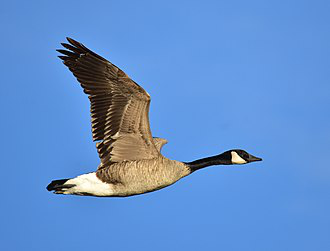

In [12]:
# Lineplot
pn.extension()

# The widgets
bird_widget = pn.widgets.Select(options= bird_list)
region_widget = pn.widgets.Select(options= region_list)
agriculture_widget = pn.widgets.Select(options= agriculture_list)
year_slider = pn.widgets.FloatSlider(name='Select year', width=200)


pn.Column('# Select parameters',region_widget ,bird_widget, agriculture_widget, year_slider, background='WhiteSmoke')

# pn.Column('# Select parameters',year_slider ,bird_widget, background='WhiteSmoke')

p1 = pn.interact(make_plot, bird = bird_list, region = region_list, agriculture = agriculture_list)
# p2 = pn.interact(creat_map_plot, bird = bird_list, year = [year for year in range(2000, 2021)])
p3 = pn.interact(image, bird = bird_list)

tabs = pn.Tabs(('Lineplot', p1), ("Bird picture", p3))

tabs

### Data quantity

In [ ]:
print("There is data available:\n" +
      f"   {len(bird_list)} bird species\n" +
      f"   {len(agriculture_list)} types of agriculture\n" +
      "   12 regions of the Netherlands\n" +
      "   From 2000-2020 from both datasets (21 years total)\n" +
      f"   {len(bird_list) * 12 * 21 * len(agriculture_list)} data points in total"
     )

print("\nPer bird species data available:\n" +
      f"   {len(agriculture_list)*12*21} data points in total\n" +
      f"   {12 * 21} data points per agriculture\n" +
      f"   {21 * len(agriculture_list)} data points per region\n" +
      f"   {len(agriculture_list)*12} data points per year\n" +
      f"   21 data points per region and agriculture"
     )

### Data quality

In [ ]:
total_data = len(bird_list) * 12 * 21 * len(agriculture_list)
missing_bird_data = bird_df.isna().sum().sum()
missing_agriculture_data = agriculture_df.isna().sum().sum()

missing_data_total = 0
for df in df_dict:
    missing_data_total =+ df_dict[df].isna().sum().sum()


print("The amount of missing data:\n" +
      f"   {missing_bird_data} missing bird points ({missing_bird_data/(len(bird_list) * 12 * 21)*100}%)\n" +
      f"   {missing_agriculture_data} missing agriculture data points ({missing_agriculture_data/(total_data/len(bird_list))*100}%)\n" +
      f"   {missing_data_total} missing data in total ({missing_data_total / total_data * 100}%)\n"
     )
